<a href="https://colab.research.google.com/github/jevylux/pytorchtraining/blob/main/pytorchworkflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# pytorch workflow  - end-to-end-workflow

what_we_are_covering = {1: "data ( prepare and load)",
                        2: "build model",
                        3: "fitting the model to data (training)",
                        4: "making predictions and evaluating a model (inference)",
                        5: "saving and loading a model",
                        6: "putting it all together"}

import torch
from torch import nn  #nn contains al od pytorch building blocks regarding nn's
import matplotlib.pyplot as plt

# check pytoprch version
print(torch.__version__)




2.1.0+cu118


In [3]:
## Data - preparing and loading
# data can be almost anything , excel spreadsheet, images, videos, audio, DNA, text

# create known parameters
weight = 0.7
bias = 0.3

# create data. with a linear regression

start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1) # unsqueeze is used to add an extra dimension. X in capital -> tensor
y = weight * X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [4]:
len(X), len(y)

(50, 50)

In [7]:
# splitting data into training and tests sets ( one of the most important concepts in deep learning
# create train/test split

train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

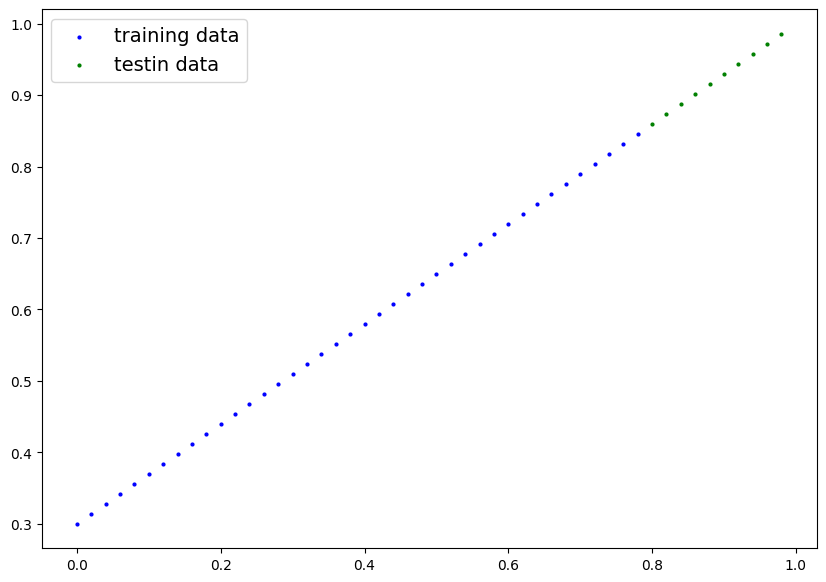

In [10]:
# how might be better visualize our data ? data explorer's mot : "visualize, visualize"
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions
  """
  plt.figure(figsize=(10,7))
  plt.scatter(train_data, train_labels, c="b", s=4, label="training data")
  plt.scatter(test_data, test_labels, c="g", s=4, label="testing data")
  if predictions is not None:
    # plot predictions if they exist
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")
  # Show the legend
  plt.legend(prop={"size": 14})

plot_predictions();

In [ ]:
# build the model
from torch import nn
# create linear regression model class
# to lear classes see : https://realpython.com/python-classes/
class LinearRegressionModel(nn.Module):  # <- almost everything n pytorch inheretest from nn.Module : https://pytorch.org/docs/stable/generated/torch.nn.Module.html
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1,
                                            requires_grad=True,
                                            dtype=torch.float))
    self.bias = nn.Paramter(torch.randn(1,
                                        requires_grad=True,
                                        dtype=torch.float))
# forward method to define the computation in the model
def forward(self,x:torch.Tensor) -> torch.Tensor: # <- "X" is the input data
  return self.weights * x + self.bias # this is the linear regression formula

